In [1]:
import math
import itertools
import numpy as np
import hoomd
import hoomd.md
import gsd.hoomd
import fresnel
import matplotlib.pyplot as plt

In [2]:
def render(snapshot):
    """Create scene from snapshot with fresnel."""
    scene = fresnel.Scene()
    geometry = fresnel.geometry.Sphere(scene, N=snapshot.particles.N, 
                                       radius=sigma)
    geometry.position[:] = snapshot.particles.position
    geometry.material = fresnel.material.Material(
        color = fresnel.color.linear([0.1, 0.8, 0.1]),
        roughness = 0.8,
        specular = 0.2)
    geometry.outline_width = 0.05
    fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=.07)
    scene.camera = fresnel.camera.Orthographic.fit(scene)
    scene.lights = fresnel.light.lightbox()
    fresnel.pathtrace(scene, light_samples=5)
    return scene

Define the number of particles $N$ and the length of the sides of the box $L$:

In [3]:
N = 13
L = 30

Define parameters for Lennard-Jones interaction:

In [4]:
sigma = 1.
epsilon = 10.

Initialize the positions of the particles:

In [5]:
spacing = sigma * 2.5
K = math.ceil(N**(1 / 3))
x = np.linspace(-L/2+sigma, L/2-sigma, K, endpoint=False)
position = list(itertools.product(x, repeat=3))[:N]

Create initial snapshot of the system

In [6]:
snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = N
snapshot.particles.position = position
snapshot.particles.orientation = [(1,0,0,0)]*N
snapshot.particles.types = ['LJ']
snapshot.particles.typeid = [0] * N
snapshot.configuration.box = [L, L, L, 0, 0, 0]

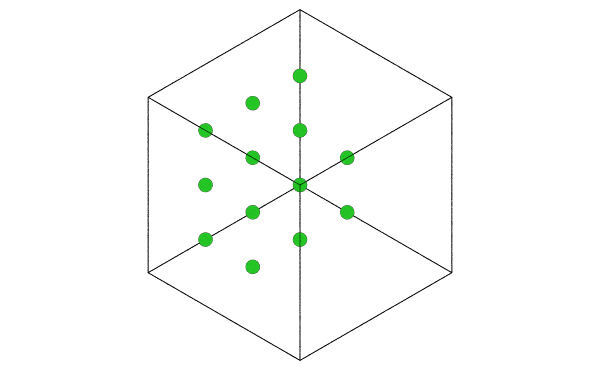

In [7]:
scene = render(snapshot)
fresnel.pathtrace(scene, light_samples=5)

Initialize the simulation object

In [8]:
device = hoomd.device.CPU()
simulation = hoomd.Simulation(device=device)
simulation.create_state_from_snapshot(snapshot)

While pair potentials are nominally defined between all pairs of particles, Molecular dynamics simulations evaluate short ranged pair potentials only $r < r_{cut}$ for to make the computation fast through the use of a neighbor list. By default, HOOMD-blue introduces a discontinuity in $V$ at $r < r_{cut}$, though there are options to shift or smooth the potential at the cutoff.

HOOMD-blue provides several neighbor list options to choose from. Cell performs well in most situations. The `buffer` parameter sets an extra distance to include in the neighbor list, so it can be used for multiple timesteps without recomputing neighbors. Choose a value that minimizes the time to execute your simulation.

In [9]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

Construct the Lennard-Jones force object to compute interactions:

In [10]:
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[("LJ", "LJ")] = {"epsilon": 1., "sigma": 1.}
lj.r_cut[("LJ", "LJ")] = 2.5

Create the Integrator object and add the forces to it:

In [11]:
integrator = hoomd.md.Integrator(dt=0.05)
integrator.forces.append(lj)

HOOMD-blue provides a number of integration methods, which define the equations of motion that apply to a subset of the particles in the system. These methods are named after the thermodynamic ensemble they implement. For example, **NVE** implements Newton’s laws while **NVT** adds a thermostat degree of freedom so the system will sample the canonical ensemble.

In [12]:
nvt = hoomd.md.methods.NVT(kT=0.05, filter=hoomd.filter.All(), tau=1.0)
integrator.methods.append(nvt)

Add the Integretor object to the Simulation object:

In [13]:
simulation.operations.integrator = integrator

When using the **NVT** integration method, you must specify non-zero initial velocities. **NVT** modifies particle velocities by a scale factor so it cannot scale a zero velocity to a non-zero one. The `thermalize_particle_momenta` method will assign Gaussian distributed velocities consistent with the the canonical ensemble. It also sets the velocity of the center of mass to 0:

In [14]:
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5)

*Warning*: Simulation.seed is not set, using default seed=0


You can inspect the snapshot to see the changes that `thermalize_particle_momenta` produced. Use the **ThermodynamicQuantities** class to compute properties of the system:

In [15]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())

**ThermodynamicQuantities** is a **Compute**, an **Operation** that computes properties of the system state. Some computations can only be performed during or after a simulation run has started. Add the compute to the operations list and call `run(0)` to make all all properties available without changing the system state:

In [16]:
simulation.operations.computes.append(thermodynamic_properties)
simulation.run(0)

There are $(3N - 1)$ degrees of freedom in the system. The **NVT** integration method conserves linear momentum, so the $-3$ accounts for the effectively pinned center of mass.

In [17]:
thermodynamic_properties.degrees_of_freedom == 3*N - 3

True

Following the equipartition theorem, the average kinetic energy of the system should be approximately $\frac{1}{2} kT N_{dof}$:

In [18]:
1 / 2 * 1.5 * thermodynamic_properties.degrees_of_freedom

27.0

In [19]:
thermodynamic_properties.kinetic_energy

21.57453894337214

Why aren't the two values equal? The instantaneous kinetic temperature $T_k$($k T_k$ in energy units here) of a finite number of particles fluctuates! The canonical ensemble holds the number of particles, volume, and the thermodynamic temperature constant. Other thermodynamic quantities like kinetic energy (and thus kinetic temperature) will fluctuate about some average. Both that average and the scale of the fluctuations are well defined by statistical mechanics.

In [20]:
logger = hoomd.logging.Logger()
logger.add(thermodynamic_properties)
logger.add(simulation, quantities=['timestep', 'walltime'])

In [21]:
gsd_writer = hoomd.write.GSD(filename='log.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='xb',
                             filter=hoomd.filter.Null())
simulation.operations.writers.append(gsd_writer)

In [24]:
gsd_writer.log = logger

In [25]:
simulation.run(1_000_000)

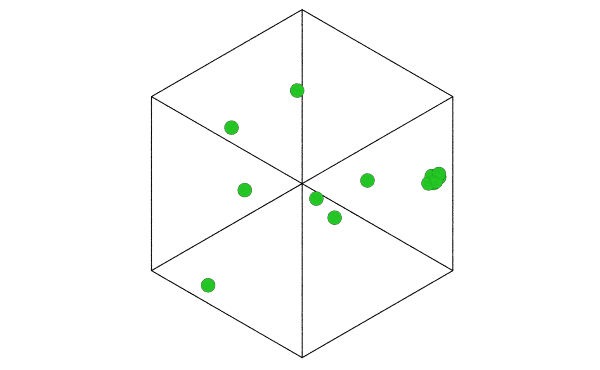

In [26]:
scene = render(simulation.state.get_snapshot())
fresnel.pathtrace(scene, light_samples=5)

In [27]:
traj = gsd.hoomd.open('log.gsd', 'rb')

In [28]:
traj[0].log['md/compute/ThermodynamicQuantities/potential_energy']

array([0.])

In [29]:
timestep = []
walltime = []
potential_energy = []

for frame in traj:
    timestep.append(frame.configuration.step)
    walltime.append(frame.log['Simulation/walltime'][0])
    potential_energy.append(
        frame.log['md/compute/ThermodynamicQuantities/potential_energy'][0])



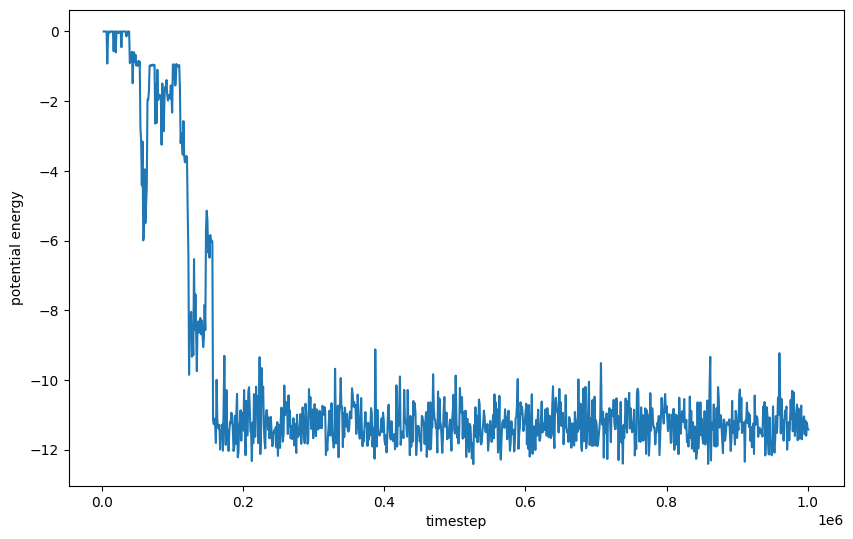

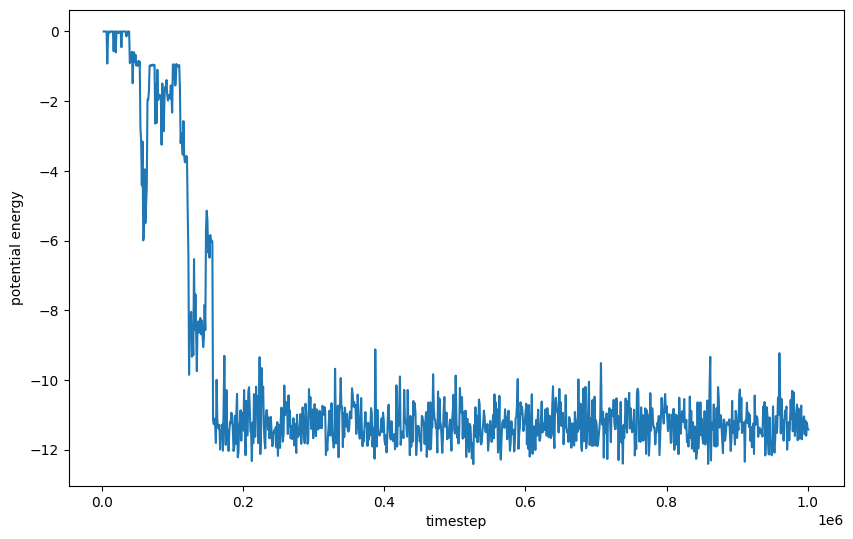

In [30]:
fig = plt.figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.plot(timestep, potential_energy)
ax.set_xlabel('timestep')
ax.set_ylabel('potential energy')
fig